In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import seaborn as sns
from tqdm.notebook import tqdm
import copy

# Introduction

Welcome to the second lab of INF8801 !
In this lab, we are going to be looking at image inpainting by searching across a database. Note that there is an associated PDF problem statement.

In the first section, we will be looking at GIST descriptors. Having a source image, we will try to find it's semantically closest pair in a database.

In the DescGIST class, you are asked to complete the functions:
- `get_gabor` : which computes a single gabor filter
- `get_all_gabors` : which computes our entire set of gabor filters
- `describe` : which computes the response of an image to our set of gabor filters.

A few tests and displays are given to ensure you're on track.  In section 1.4., we will consider each image in the database, and you must find its closest pair. Don't forget to answer the questions !

---

The second section is independent of the first one. We suppose we have found a pair of images (src and target) and that our src image has a patch we want to inpaint. Your goal is to implement Poisson's method using Jacobi's algorithm (see pdf for links). 

Complete the function `poisson_blending`.

For each test in the data/testPoisson folder, we ask you to show:
- the src image
- the target image
- intermediate results of the algorithm
- your final image (i.e. the inpainted src image) and the corresponding iteration

---


Please rename the file with both or your last names.


# 1. GIST Descriptor

> **CODE :**
>
> Implement `get_gabor`, `get_all_gabors` and `describe` functions in the `DescGIST` class.

In [2]:
class DescGIST():
    def __init__(self):
        self.nb_orientations = 6    # Number of orientations of our filters
        self.nb_scales = 5          # Number of scales of our filters
        self.grid_size = 4          # Response of an image to our descriptor will be resiezd to a grid of size 4x4

        self.filter_size = 64       # Each filter will be of size filter_size x filter_size
        self.imsize=128             # Input images will be resized during description
        self.filters = np.zeros((self.filter_size, self.filter_size, self.nb_scales, self.nb_orientations)) #Where we will store our filter
        self.values = np.zeros((self.grid_size, self.grid_size, self.nb_scales, self.nb_orientations)) # Where we will store the response of an image to the descriptor


    def get_gabor(self, theta: float, lda: float, sigma_x: float, sigma_y: float) -> np.ndarray:
        """Returns a Gabor filter for the specified inputs
        Args:
            - theta (float): rotation angle in rads
            - lda (float): wave length (in pixels)
            - sigma_x (float): std of the gaussian in the direction of the wave
            - sigma_y (float): std of the gaussian perpendicular to the wave
        Returns:
            - filter (np.ndarray): Corresponding Gabor filter

        """

        X = np.tile(np.linspace(-self.filter_size/2, self.filter_size/2, self.filter_size), (self.filter_size, 1))
        Y = X.copy().T

        ################################################################################################################
        ############################################ Complete the code !################################################
        ################################################################################################################


        X_prime = X * np.cos(theta) - Y * np.sin(theta)
        Y_prime = X * np.sin(theta) + Y * np.cos(theta)
        result = np.exp(-0.5 * (X_prime**2 / sigma_x**2 + Y_prime**2 / sigma_y**2)) * np.sin(2 * np.pi * X_prime / lda)
        result = result / (2 * np.pi * sigma_x * sigma_y)
    
        return result





    def get_all_gabors(self) -> np.ndarray:
        """Computes a set of Gabor filters (4D np.array)
        Returns:
            - filters (np.ndarray): 4D array of filters, shape as shape self.filters
        """
        filters = np.zeros_like(self.filters)

        ################################################################################################################
        ############################################ Complete the code !################################################
        ################################################################################################################

        orientation_interval = - np.pi / self.nb_orientations

        result = np.zeros((self.filter_size, self.filter_size, self.nb_scales, self.nb_orientations))
        for nscale in range(self.nb_scales):
            scale =  self.filter_size / (2 ** (nscale+1))
            lda = scale
            sigma_x = scale / 2
            sigma_y = scale 
            for norientation in range(self.nb_orientations):            

                theta = norientation * orientation_interval
                result[:,:,nscale,norientation] = self.get_gabor(theta, lda, sigma_x, sigma_y)

        self.filters = result        
        return result


    def display_filters(self) -> None:
        """Simple function for visualising your computed filters
        """
        filters = self.filters
        h,w,n,m = filters.shape
        s = np.zeros((h*n, w*m))
        for y in range(n):
            for x in range (m):
                filter = filters[:,:,y,x]
                filter = filter / np.max(np.abs(filter))

                s[y*w:(y+1)*w, x*h:(x+1)*h] = filter
        f = plt.gcf()
        plt.axis("off")
        plt.imshow(s, cmap='gray')
        return f

    def describe(self, image: np.ndarray) -> None:
        """Computes the response of an image to the filters stored in self.filters
        Args:
            - image (np.ndarray): 2D
        Returns:
            - None, stores in self.values the resized responses of an image to the self.filters
        """
        if len(image.shape) >= 3 and image.shape[-1] > 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        values = np.zeros_like(self.values)

        ################################################################################################################
        ############################################ Complete the code !################################################
        ################################################################################################################

        image = cv2.resize(image, (self.imsize, self.imsize))
        for i in range(self.nb_scales):
            for j in range(self.nb_orientations):
                values[:,:,i,j] = np.abs(cv2.resize(scipy.ndimage.convolve(image, self.filters[:,:,i,j]), (self.grid_size, self.grid_size)))

        self.values = values       
      

    def distance(self, d2: 'DescGIST') -> float:
        """Computes the distance between the object and another object of class descriptor
        Args:
            - d2 (DescGIST): Another descriptor object
        Returns:
            - distance (float): distance between self.values and d2.values
        """
        return np.linalg.norm(self.values - d2.values)

    def display(self) -> None:
        """
        A method for visualising the response of an image to our descriptor. 
        Recall that our response is a grid of size (grid_size x grid_size). 
        For each cell of that grid, we sum the response of the image for every scale and orientation. 
        We also flip twice (horizontally and vertically) the responses to account for symmetry.
        """
        if not np.any(self.values):
            print("Descriptor values haven't been computed")
            return False
        s = 256
        res = np.zeros((self.grid_size*s,self.grid_size*s))
        # Initialise diagram
        x = np.tile(np.linspace(-1, 1, s), (s, 1))
        y = x.copy().T

        theta = np.arctan2(y,x)
        r = np.sqrt(x**2 + y**2)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                diagram = np.zeros((s, s))

                for scale in range(self.nb_scales):
                    for orientation in range(self.nb_orientations):
                        frag = np.ones((s, s))
                        orientationValue = (orientation/self.nb_orientations) * np.pi
                        orientationDistance = np.min((np.abs(theta - orientationValue), np.abs(theta - orientationValue + 2*np.pi)), axis = 0)
                        frag[orientationDistance > 2*np.pi/self.nb_orientations] = 0
                        frag[r < 0.8*((scale/self.nb_scales)**0.7) +0.1] = 0
                        frag[r > 0.8*(((scale+1)/self.nb_scales)**0.7) +0.1] = 0

                        #symetry
                        frag += np.flip(np.flip(frag, 0), 1)
                        diagram += frag*self.values[i, j, scale, orientation]

                res[i*s:(i+1)*s, j*s: (j+1)*s] = diagram
        f = plt.gcf()
        plt.imshow(res)
        plt.axis("off")
        # f.savefig("display.png")
        return f



### 1.2. Visualizing the gabor filters

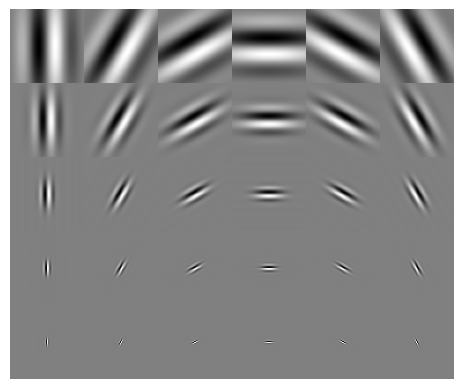

In [3]:
d =DescGIST()
d.get_all_gabors()
f = d.display_filters()
f.savefig("filters.png")

### 1.3. Visualizing the response of an image to our filters

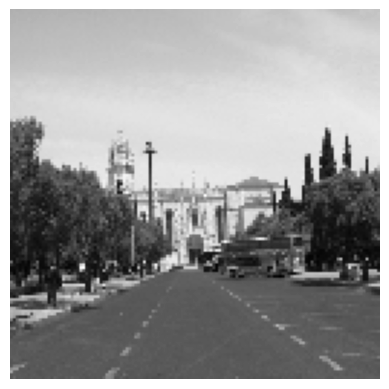

In [4]:
im = cv2.imread("./data/testGist/street.jpg")
grayscale = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), (128,128))
f = plt.gcf()
plt.imshow(grayscale, cmap='gray')
plt.axis("off")
f.savefig("grayscale.png", dpi=100)

#### Visualising a response to a single filter

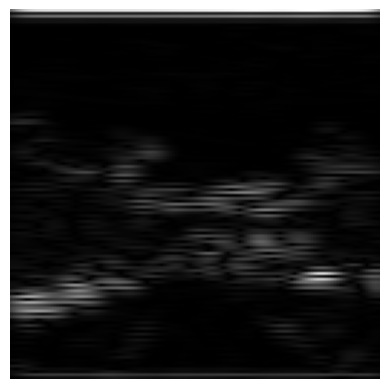

In [5]:
scale = 3
orientation = 3
grayscale = cv2.normalize(grayscale, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
response = np.abs(scipy.ndimage.correlate(grayscale, d.filters[:,:,scale, orientation], mode='constant'))
f = plt.gcf()
plt.imshow(response, cmap='gray')
plt.axis("off")
f.savefig("responseSIngleFilter.png", dpi=100)

#### Visualizing the response to all filters

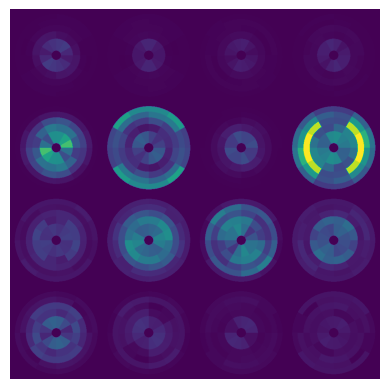

In [6]:
d.describe(grayscale)
res = d.display()
res.savefig("display.png")

> **QUESTION :**
>
>Why do we choose orientations inside `[0, Pi[` only? Why not cover the entirety of `[0, 2Pi[` ?
>
> **Réponse :**
>
>La fonction de gabords sont symétriques, donc un filtre de gabord sera le même pour une orientation de theta que pour un orientation de theta+pi

> **QUESTION :**
>
>Why do we choose to resize the input image?
>
> **Réponse :**
>
> On redimensionne l'image pour gagner en éfficacité car une image de grande dimension causerait un temps de calcul plus conséquent pour obtenir la convolution avec le filtre de gabor

> **QUESTION :**
>
> Considering the resulting descriptor as seen above, is there any difference between using either a convolution or a correlation operation between the image and the filter? Briefly explain why or why not.
>
> **Réponse :**
>
> Une convolution retourne verticalement et horizontalement les filtres avant de calculer la réponse l'image, alors que dans une correlation le filtre est appliqué directement sur l'image. Dans le cas de filtre de Gabord il n'y a pas de différence entre une convolution et une correlation car les filtres de Gabords sont invariant à ces symétries.

### 1.4. Computing GIST descriptors on the whole database

In [7]:
def compare_images(data_path: str) -> np.ndarray:
    """Compares images and prints a seaborn array
    Args:
        - data_path (str): path to our images
    Returns:
        - distances (np.ndarray): 2D array of distances between images
    """
    objects = os.listdir(data_path)
    objects_names = [x.split('.')[0] for x in objects]
    objects_names.sort()
    descriptors = []

    print("Generating descriptors")
    for obj, name in tqdm(zip(objects, objects_names)):
        image = cv2.imread(os.path.join(data_path, obj))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        descriptor = DescGIST()
        descriptor.get_all_gabors()
        descriptor.describe(image)
        descriptors.append(descriptor)
    print("Computing distances")
    n = len(descriptors)
    distances = np.zeros((n,n))
    for i, d1 in tqdm(enumerate(descriptors)):
        for j in range(i, n):
            dist = d1.distance(descriptors[j])
            distances[i,j] = dist
            distances[j,i] = dist

    sns.heatmap(distances, xticklabels=objects_names, yticklabels=objects_names)
    return distances

Generating descriptors


0it [00:00, ?it/s]

Computing distances


0it [00:00, ?it/s]

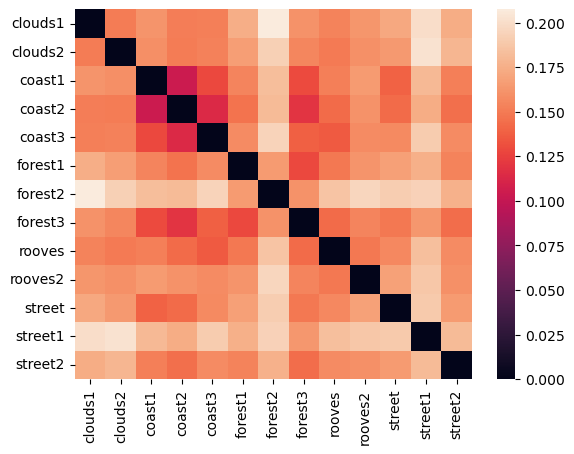

In [8]:
distances = compare_images('./data/testGist/')

>**QUESTION :**
> 1. Interpret the heatmap. (5-10 lines)
> 2. For each image, what would be the closest image according to GIST descriptors? Is that semantically consistent?
>
> **Réponse :**
>
> 1. Cette heat map permet de visualiser chaque couple de distance entre les réponses au filtre de gabord de chaque image. Pour commencer on peut remarquer que l'image forest2 ressemble très peu à toutes les autres images de notre data set avec une légère similarité pour l'image forest1. On peut également noter des faibles distances des images coast entre elles. 
> 2. Pour chaque image on a les correspondances suivantes : \
>clouds1:  clouds2 \
>clouds2 : rooves \
>coast1 : coast2 \
>coast2 : coast1 \
>coast3 : coast2 \
>forest1 : forest3 \
>forest2 : forest3 \
>forest3 : coast2 \
>rooves : coast3 \
>rooves2 : rooves \
>street : coast1 \
>street1 : forest3 \
>street2 : forest3 \
> Ces correspondances pour les classes coast, forest, clouds et rooves sont majoritairement sématiquement correctes, cependant pour la classe street toutes les images associées ne font pas partis de la classe street.

### Finding the closest image to another image

In [9]:
objects = os.listdir("./data/testGist")
objects_names = [x.split('.')[0] for x in objects]
for i in range (len(distances)):
    obj = objects_names[i]
    dist = distances[i, :]
    dist[i] = np.inf
    match = np.argmin(dist)
    print(obj, "<->", objects_names[match])

clouds1 <-> clouds2
clouds2 <-> rooves
coast1 <-> coast2
coast2 <-> coast1
coast3 <-> coast2
forest1 <-> forest3
forest2 <-> forest3
forest3 <-> coast2
rooves <-> coast3
rooves2 <-> rooves
street <-> coast1
street1 <-> forest3
street2 <-> forest3


# 2. Poisson Blending

The function below could be useful to you. It computes the correlation of a 2D filter on an image that can have one or more channels.
If the variable "image" is an RGB image for example, the 2D kernel is passed along each channel independntly, and returns the correlated RGB image.
See `scipy.ndimage.correlate` for more information

In [10]:
def correlate(image: np.ndarray, kernel: np.ndarray, mode: str) -> np.ndarray:
    """Correlates an image with a kernel
    Args:
        - image (np.ndarray): the RGB image on which we perform correlation
        - kernel (np.ndarray): the correlation kernel
        - mode (str): the mode for the correlation
    Returns:
        - result (np.ndarray): the result of the correlation
    """
    result = np.empty_like(image)
    if len(image.shape) == 2:
        nChannels = 1
    else:
        nChannels = np.min(image.shape)
    for channel in range(nChannels):
        result[:, :, channel] = scipy.ndimage.correlate(image[:,:,channel], kernel, mode=mode)

    return result

###  2.1. Preparing data

In [11]:
# SRC image is a png. It has a fourth channel called transparency. To get the 4D image, we load it using cv2.IMREAD_UNCHANGED
# We then extract the src image (BGR that we convert to RGB) and the transparency as two separate arrays
src = cv2.imread("./data/testPoisson/test2/src.png", cv2.IMREAD_UNCHANGED)
transparency = src[:,:,3]
src = src[:,:,:3]
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

# We extract the target array and convert it to RGB
target = cv2.imread("./data/testPoisson/test2/target.png")
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

# Having access to the transparency gives us access to the pixels that have been shaded in our source image, vs the pixels that we want to keep intact. The latter will be stored in fixed_areas
transparency = transparency / np.max(transparency)
fixed_areas = transparency>0.5

# We scale our images to [0,1]
src = src /255
target = target /255

### 2.2. Implementing Jacobi's method

The Poisson blending problem can be described as such : 

"The laplacian of the target is equal to the divergence of the source, where the transparency = 0."

To solve this problem (since we don't know the value of the divergence of the blended source), we use an algorithm called Jacobi's method, which converges towards a solution to the equation. Iteratively update the source image in this way : 

"The value of every non-fixed pixel in the source image is equal to the mean value of it's neighbors + laplacian of the target."

Locking strict boundaries for the part of the image we wish to inpaint will allow us to iteratively propagate the appropriate values of the divergence of the source. *Thus, make sure to modifiy only the non-fixed pixels of the source image.*

Note : You can modify the signature of the function `poisson_blending()` to return multiple outputs and/or take different inputs if you wish to. Just make sure that you are able to plot what we ask for and know the final iteration of your algorithm.

> **CODE :**
>
> Implement the `poisson_blending` function.

In [12]:
def poisson_blending(src: np.ndarray, target: np.ndarray, fixed_areas: np.ndarray, nb_iter: int) -> np.ndarray:
    """
    This function computes the blended image between the src and target images, 
    only in the ROI specified in the fixed_areas logical image.

    Hint : use the correlate function above to apply a kernel to an image
    Hint : use the kernels defined below to compute the mean values of the 
           neighboring pixels (divergence kernel) and the laplacian of an image (laplacian kernel)
    Hint : make sure that you are working in a copy of the src image and not the src image itself 

    You need to : 
    - Compute the laplacian of the target
    - Iteratively modify the src image, only in the non fixed areas, using Jacobi's method
    - Plot the blended image (not each iteration but at a fixed step) 


    Args:
        - src (np.ndarray): the RGB image in which we want to do the inpainting
        - target (np.ndarray): the 3D image that we want to add into the src image
        - fixed_areas (np.ndarray): a binary image (mask) that represents the pixels to inpaint
        - nb_iter (int): int, a number of iterations to run
    
    Returns:
        - result (np.ndarray) : the blended image

    """
    # Initialize divergence kernel and laplacian kernel
    div_kernel = np.array([[0,1,0],
                      [1,0,1],
                      [0,1,0]])
    lap_kernel = np.array([[0,-0.25,0],
                      [-0.25,1,-0.25],
                      [0,-0.25,0]])

    ################################################################################################################
    ############################################ Complete the code !################################################
    ################################################################################################################

    result = src.copy()
    fixed_areas_RGB = np.array([fixed_areas, fixed_areas, fixed_areas]).transpose(1,2,0)
    inv_fixed_areas_RGB = 1 - fixed_areas_RGB

    laplacian = correlate(target, lap_kernel, 'constant')
    
    # Calculate the number of rows and columns for the subplots
    nrows = 1
    ncols = 5  # Change this to the number of columns you want

    # Create the subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))

    # Initialize a counter for the images
    img_counter = 0

    for i in range(nb_iter+1):

        if i % (nb_iter//4) == 0:

            col = img_counter % ncols

            # Display the image in the subplot
            axs[col].imshow(result)
            axs[col].axis("off")

            # Add a title to the subplot
            axs[col].set_title(f"Iteration {i}")

            img_counter += 1

        meanValues = correlate(result, div_kernel, 'constant')
        new_pixels = np.clip((meanValues/4 + laplacian), 0, 1)

        result = inv_fixed_areas_RGB * new_pixels + fixed_areas_RGB * result        
        result = np.clip(result, 0, 1)

        

    # Save the figure with all the images
    fig.savefig("all_images.png", dpi=100)

    return result
        


    


### 2.3. Displaying results

> **QUESTION :**
> 
> For each test in the data/testPoisson folder, we ask you to show:
> - The source image
> - The target image
> - Some intermediate results of the algorithm
> - Your final image (i.e. the inpainted src image) and the corresponding iteration you find acceptable.
>
> Beware, for images with larger regions to inpaint, the algorithm can take many iterations to converge. If you do not like the trial-and-error approach of setting a max number of iterations, you are encouraged to implement a stopping criterion as mentioned in the next question (although it is optional).


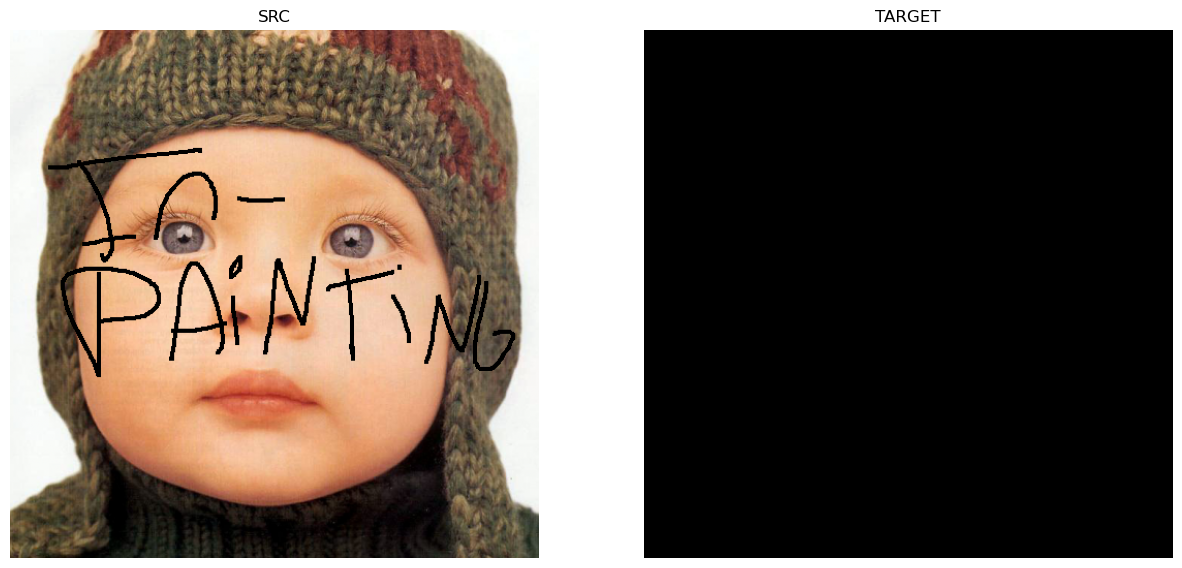

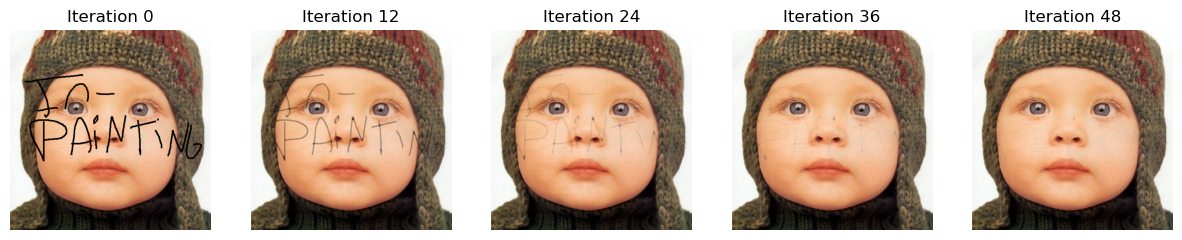

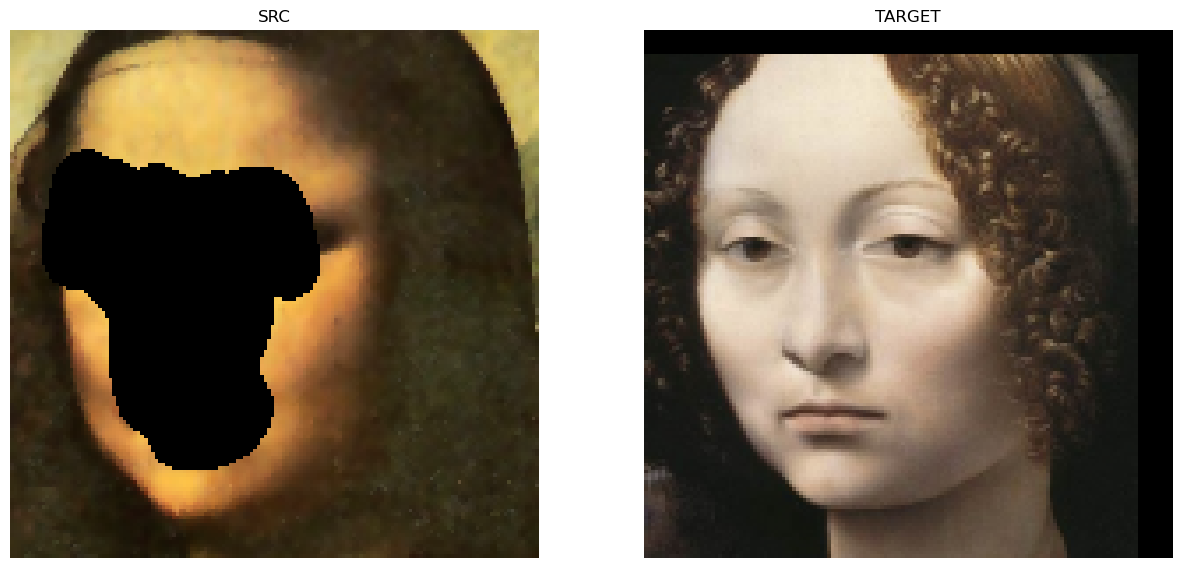

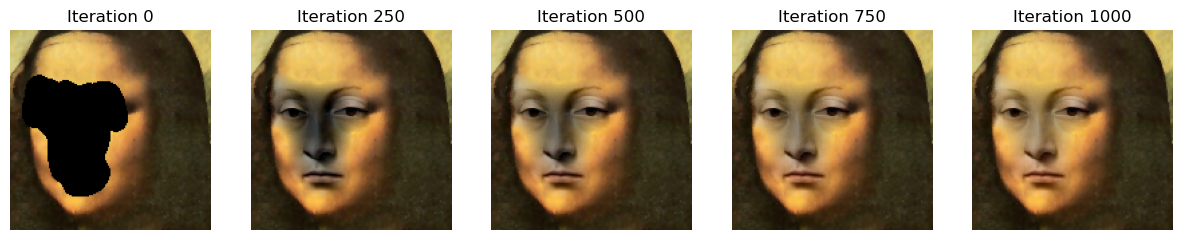

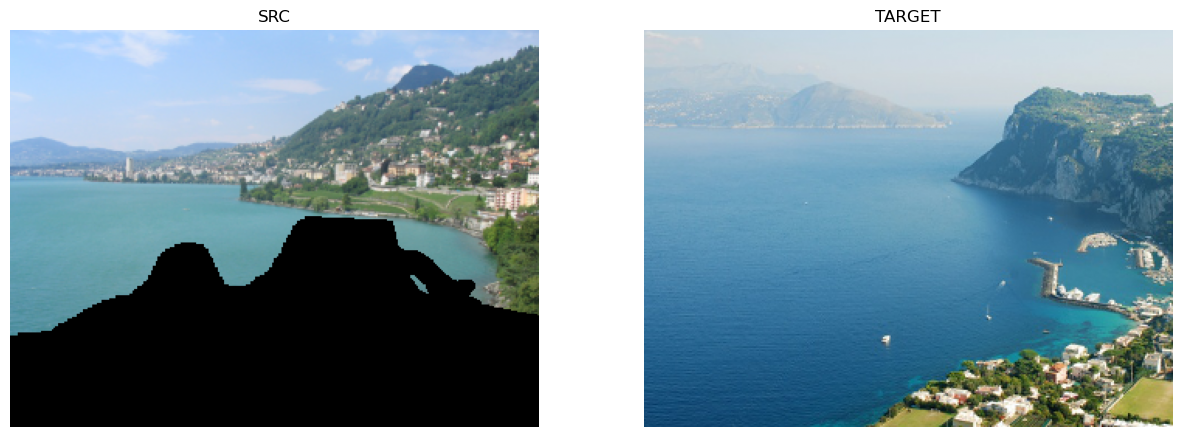

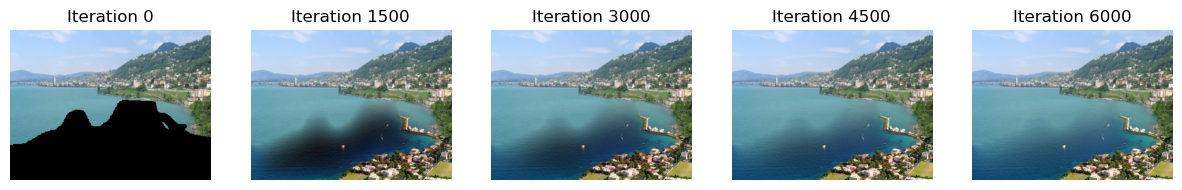

In [13]:
#For each test in the data/testPoisson folder
#Load the src and target images
#Load the fixed areas

for i in range(1, 4):
    src = cv2.imread(f"./data/testPoisson/test{i}/src.png", cv2.IMREAD_UNCHANGED)
    transparency = src[:,:,3]
    src = src[:,:,:3]
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

    target = cv2.imread(f"./data/testPoisson/test{i}/target.png")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    transparency = transparency / np.max(transparency)
    fixed_areas = transparency>0.5

    src = src /255
    target = target /255

    nb_iter = 1000
    if (i == 3):
        nb_iter = 6000
    elif (i == 1):
        nb_iter = 50

    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(src)
    axs[0].axis("off")
    axs[0].set_title("SRC")
    axs[1].imshow(target)
    axs[1].axis("off")
    axs[1].set_title("TARGET")
    

    result = poisson_blending(src, target, fixed_areas, nb_iter)
    f = plt.gcf()
    plt.imshow(result)
    plt.axis("off")
    f.savefig(f"result{i}.png", dpi=100)


> **QUESTION :**
>
> Clearly, only one value for the maximum number of iterations cannot suit all images. Think of a way to stop the algorithm automatically. Give some details about how you would implement it. (Open question)
>
> **Réponse :**
>
> Une méthode pour arréter automatiquement le blending de poisson pourrait consister à calculer la distance de couleur des pixels de la zone à compléter entre deux itérations. Si cette distance est inférieur à un seuil que l'on a déterminé, alors le blending de Poisson ne fait plus réellement évoluer l'image et on peut arréter le processus.